# King County Temperature Exploration

In [80]:
import geojson

def load_data(filename):
    """
    Loads GeoJson Data from "filename"
    """
    with open(filename) as f:
        data = geojson.load(f)
    return data

In [81]:
washington_counties_data = load_data('Washington_Counties_with_Natural_Shoreline___washsh_area.geojson')

In [82]:
def get_king_county():
    """
    Returns the GeoJson feature for King County
    """
    for feature in washington_counties_data['features']:
        if feature['properties']['COUNTY'].casefold() == 'king'.casefold():
            return feature

In [83]:

from shapely.geometry import shape, Point

king_county = get_king_county()

king_county_shape = shape(king_county['geometry'])
buffered_king_county_shape = king_county_shape.buffer(0.05)

buffered_king_county_shape_geojson = geojson.Feature(geometry=buffered_king_county_shape, properties={})

In [84]:
# https://api.weather.gov/stations?state=WA&limit=500

import requests

def get_features(geojson_data):
    return geojson_data['features']


def get_king_county_weather_stations():
    king_county_stations = []
    
    limit = 500
    state = 'WA'
    
    url = f'https://api.weather.gov/stations?state={state}&limit={limit}'
    
    response = requests.get(url)
    geojson_data = geojson.loads(response.text)
    next_url = geojson_data['pagination']['next']
    features = get_features(geojson_data)
    
    while features:
        for feature in features:
            point = shape(feature['geometry'])
            if king_county_shape.contains(point):
                king_county_stations.append(feature)
        
        response = requests.get(next_url)
        geojson_data = geojson.loads(response.text)
        next_url = geojson_data['pagination']['next']
        features = get_features(geojson_data)
        
    print(f'Found {len(king_county_stations)} stations in King County')
    return king_county_stations
    
king_county_stations = get_king_county_weather_stations()
    

Found 254 stations in King County


In [85]:
def get_temperature_at_station(station_id):
    url = f'https://api.weather.gov/stations/{station_id}/observations/latest'
    response = requests.get(url)
    if response.status_code != 200:
        return None
    geojson_data = geojson.loads(response.text)
    temperature = geojson_data['properties']['temperature']['value']
    return temperature

def get_temperatures_at_stations(stations):
    temperatures = {}
    for station in stations:
        station_id = station['properties']['stationIdentifier']
        temperature = get_temperature_at_station(station_id)
        if temperature:
            temperatures[station_id] = temperature
    return temperatures

temperatures = get_temperatures_at_stations(king_county_stations)


In [102]:
def get_elevation_of_coordinates(latitude, longitude):
    url = f'https://epqs.nationalmap.gov/v1/json?x={longitude}&y={latitude}&units=Meters&wkid=4326&includeDate=False'
    response = requests.get(url)
    if response.status_code != 200:
        return None
    data = response.json()
    return data['value']

def get_elevation_of_station(station):
    latitude = station['geometry']['coordinates'][1]
    longitude = station['geometry']['coordinates'][0]
    return get_elevation_of_coordinates(latitude, longitude)

In [103]:
station_elevations = {}
for station in king_county_stations:
    elevation = get_elevation_of_station(station)
    station_elevations[station['properties']['stationIdentifier']] = elevation
    
import pickle
def write_elevations_to_file(elevations, filename):
    with open(filename, 'wb') as f:
        pickle.dump(elevations, f)
        
write_elevations_to_file(station_elevations, 'station_elevations.pkl')

{'ALP31': -2.28, 'ALP55': -3.14, 'AV031': 5, 'CDVW1': 4.22, 'CUMW1': -0.3, 'FMWW1': 3.62, 'IDXW1': 2.7, 'KBFI': 5.6, 'KRNT': 6.7, 'KSEA': 5.6, 'KUSW1': -0.2, 'LSFW1': -0.56, 'MGSW1': 0.3, 'MPSW1': -0.8, 'MTW43': -2.83, 'OMWW1': -0.5, 'RCCW1': 4.86, 'RXSW1': -0.4, 'SAWW1': -0.8, 'SBKW1': 5.73, 'SMPW1': -1.4, 'SNO30': -0.92, 'STB48': -4.64, 'STOW1': 0.53, 'STS40': -2.26, 'STS48': -4.87, 'STS52': 0.25, 'STS54': -4.77, 'SVNW1': -1.3, 'T130T': 5.7, 'T144T': 6, 'T195T': 12.2, 'TALPE': -1.5, 'TCURT': 0.5, 'TDENN': -0.2, 'TFRAN': -0.9, 'THOME': 1.6, 'TKENT': 6.9, 'TKSW1': 0.5, 'TNFW1': 3.66, 'TSR18': 3.4, 'TSUNS': 5.4, 'TTANN': 3.8}


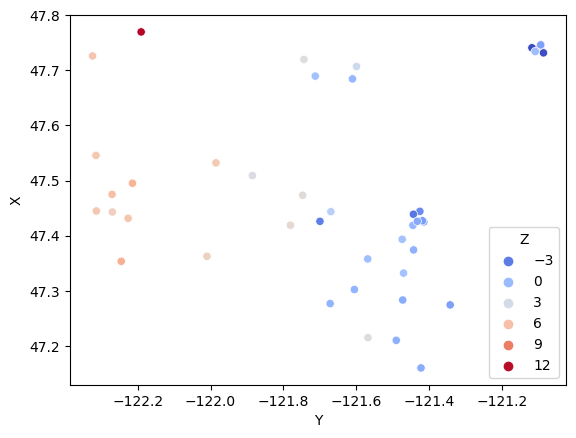

In [125]:
import folium

coords = tuple(reversed(king_county_shape.centroid.coords[0]))

m = folium.Map(location=coords, zoom_start=9)
folium.GeoJson(buffered_king_county_shape).add_to(m)

print(temperatures)

valid_king_county_stations = []

plot_points = []
for station in king_county_stations:
    station_name = station['properties']['name']
    if station['properties']['stationIdentifier'] in temperatures.keys():
        temperature = temperatures[station['properties']['stationIdentifier']]
        valid_king_county_stations.append(station)
        
        plot_points.append((station['geometry']['coordinates'][1], station['geometry']['coordinates'][0], temperature))
    else:
        continue
    
    elevation = station_elevations[station['properties']['stationIdentifier']]
    coords = tuple(reversed(shape(station['geometry']).coords[0]))
    folium.Marker(location=coords, popup=f"{station_name} - {elevation}m - {temperature}C").add_to(m)

folium.LayerControl().add_to(m)

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

x = [point[0] for point in plot_points]
y = [point[1] for point in plot_points]
z = [point[2] for point in plot_points]

df = pd.DataFrame({'X': x, 'Y': y, 'Z': z})

plot = sns.scatterplot(x='Y', y='X', hue='Z', palette='coolwarm', data=df)

plt.show()


In [113]:
from sklearn.neighbors import KDTree
import numpy as np

station_array = np.empty((0, 3))

for station in valid_king_county_stations:
    coordinates = tuple(reversed(station['geometry']['coordinates']))
    elevation = station_elevations[station['properties']['stationIdentifier']]
    temperature = temperatures[station['properties']['stationIdentifier']]
    
    np_array = np.array([coordinates[0], coordinates[1], elevation]).reshape(1, 3)
    station_array = np.append(station_array, np_array, axis=0)
    
    
print(station_array[:, :3])
kd_tree = KDTree(station_array[:, :3])

def get_temperature_at_coordinates(lat, lon, elevation):
    new = np.array([lat, lon, elevation]).reshape(1, 3)
    dist, ind = kd_tree.query(new, k=3)
    
    for i in ind[0]:
        station = valid_king_county_stations[i]
        temperature = temperatures[station['properties']['stationIdentifier']]

    avg_temperature = 0
    for i in ind[0]:
        station = valid_king_county_stations[i]
        temperature = temperatures[station['properties']['stationIdentifier']]
        avg_temperature += temperature

    return avg_temperature / len(ind[0])


[['47.44407' '-121.42485' '943.232788086']
 ['47.43882' '-121.44262' '1658.210571289']
 ['47.44283' '-122.26967' '96.534744263']
 ['47.41889' '-121.78028' '312.935852051']
 ['47.27666' '-121.67138' '991.369262695']
 ['47.21472' '-121.5675' '529.468688965']
 ['47.70694' '-121.59889' '564.979492188']
 ['47.54548' '-122.3147' '6.868483543']
 ['47.49509' '-122.21437' '7.120347500']
 ['47.44472' '-122.31361' '114.575302124']
 ['47.68433' '-121.61007' '1029.502929688']
 ['47.21' '-121.48972' '494.470123291']
 ['47.35768' '-121.56812' '870.444702148']
 ['47.28312' '-121.47197' '975.566284180']
 ['47.42593' '-121.69938' '1347.428710938']
 ['47.37406' '-121.44213' '1219.303955078']
 ['47.3625' '-122.00972' '173.642333984']
 ['47.30218' '-121.60475' '1151.771240234']
 ['47.15992' '-121.42172' '1415.543457031']
 ['47.43139' '-122.22639' '8.660542488']
 ['47.27427' '-121.34162' '1179.148071289']
 ['47.42487' '-121.41395' '916.983398438']
 ['47.73758' '-121.10732' '1476.718139648']
 ['47.68944' '-1

In [106]:
new_temperature = get_temperature_at_coordinates(47.79378, -121.84576, 271.8816)

folium.Marker(location=(47.79378, -121.84576), popup=f"Marckworth Cliff - {new_temperature}C").add_to(m)

m

47.79378, -121.84576 -- SR18 INTERCHANGE ECHO LAKE - 3.4C
47.79378, -121.84576 -- CEDAR RIVER AT POWERPLANT NEAR CEDAR FALLS 1SW - 4.22C
47.79378, -121.84576 -- NORTH FORK TOLT RIVER ABOVE YELLOW CREEK NEAR CARNATION 10NE - 3.66C


In [107]:
buffered_king_county_shape_minx, buffered_king_county_shape_miny, buffered_king_county_shape_maxx, buffered_king_county_shape_maxy = buffered_king_county_shape.bounds

print(buffered_king_county_shape_minx, buffered_king_county_shape_miny, buffered_king_county_shape_maxx, buffered_king_county_shape_maxy)

-122.57791116552559 47.034688700390525 -121.015946 47.830580712778


In [108]:
x_steps = 20
y_steps = 20

points = []

for x in range(x_steps):
    for y in range(y_steps):
        x_val = buffered_king_county_shape_minx + (buffered_king_county_shape_maxx - buffered_king_county_shape_minx) * x / x_steps
        y_val = buffered_king_county_shape_miny + (buffered_king_county_shape_maxy - buffered_king_county_shape_miny) * y / y_steps
        points.append((y_val, x_val))
        
print(points)

[(47.034688700390525, -122.57791116552559), (47.0744833010099, -122.57791116552559), (47.11427790162927, -122.57791116552559), (47.154072502248646, -122.57791116552559), (47.19386710286802, -122.57791116552559), (47.23366170348739, -122.57791116552559), (47.273456304106766, -122.57791116552559), (47.31325090472614, -122.57791116552559), (47.35304550534551, -122.57791116552559), (47.392840105964886, -122.57791116552559), (47.43263470658427, -122.57791116552559), (47.47242930720364, -122.57791116552559), (47.512223907823014, -122.57791116552559), (47.55201850844239, -122.57791116552559), (47.59181310906176, -122.57791116552559), (47.631607709681134, -122.57791116552559), (47.67140231030051, -122.57791116552559), (47.71119691091988, -122.57791116552559), (47.750991511539254, -122.57791116552559), (47.79078611215863, -122.57791116552559), (47.034688700390525, -122.49981290724931), (47.0744833010099, -122.49981290724931), (47.11427790162927, -122.49981290724931), (47.154072502248646, -122.4

In [121]:
m2 = folium.Map(location=coords, zoom_start=9)

grid_temps = {}
king_county_points = []
for point in points:
    if buffered_king_county_shape.contains(Point(tuple(reversed(point)))):
        king_county_points.append(point)
        
for point in king_county_points:
    temperature = get_temperature_at_coordinates(point[0], point[1], get_elevation_of_coordinates(point[0], point[1]))
    grid_temps[point] = temperature
    folium.Marker(location=point, popup=f'Temperature: {temperature}C').add_to(m2)
    
m2

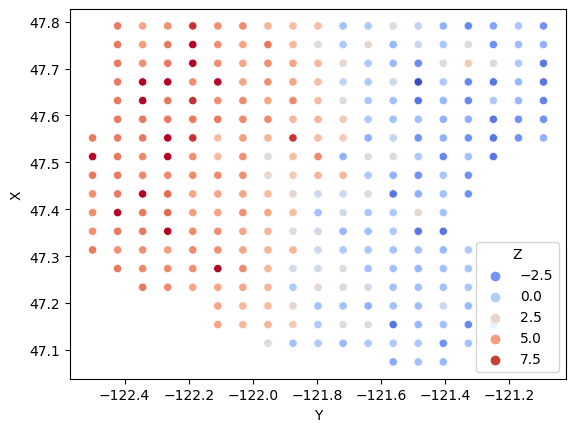

In [124]:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

x = [point[0] for point in king_county_points]
y = [point[1] for point in king_county_points]
z = [grid_temps[point] for point in king_county_points]

df = pd.DataFrame({'X': x, 'Y': y, 'Z': z})

plot = sns.scatterplot(x='Y', y='X', hue='Z', palette='coolwarm', data=df)

plt.show()
